Knots | GCV Score  | Status
------------------------------
1     | 0.4135     | *
2     | 0.5065     | 
3     | 0.1176     | *
4     | 0.0861     | *
5     | 0.0586     | *
6     | 0.0337     | *
7     | 0.0369     | 
8     | 0.0299     | *
------------------------------
Best: 8 Knots (Lowest GCV)

Final Knot Locations: [1.11 2.22 3.33 4.44 5.56 6.67 7.78 8.89]


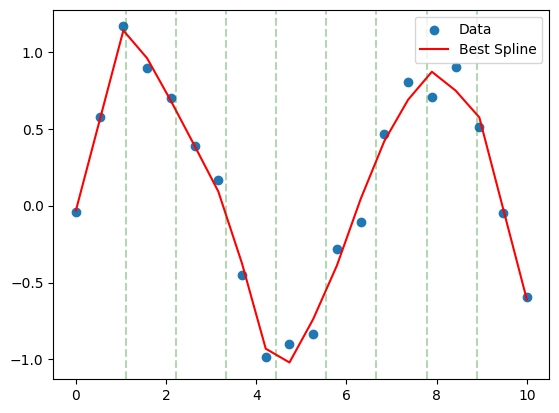

In [15]:
import numpy as np
import matplotlib.pyplot as plt

# OLS Model Class
class Model():
    def __init__(self):
        self.intercept_ = None
        self.coef_ = None

    def fit(self, X_features, y_target):
        X_with_bias = np.insert(X_features, 0, 1, axis=1)
        X_transpose = X_with_bias.T
        try:
            XtX = X_transpose @ X_with_bias
            XtX_inv = np.linalg.pinv(XtX) 
            weights = XtX_inv @ (X_transpose @ y_target)
        except np.linalg.LinAlgError:
            print("Matrix Singular! Returning zero weights")
            weights = np.zeros(X_features.shape[1] + 1)
            
        self.intercept_ = weights[0]
        self.coef_ = weights[1:]
        
    def predict(self, X_new):
        return np.dot(X_new, self.coef_) + self.intercept_

# Helper Functions
def get_quantile_knots(x_data, n_knots):
    if n_knots < 1: return np.array([])
    percentiles = np.linspace(0, 100, n_knots + 2)[1:-1]
    return np.percentile(x_data, percentiles)

def create_spline_features(x_data, knots):
    X_matrix = x_data.reshape(-1, 1)
    for k in knots:
        spline_col = np.maximum(0, x_data - k).reshape(-1, 1)
        X_matrix = np.hstack([X_matrix, spline_col])
    return X_matrix

def calculate_gcv(y_true, y_pred, n_knots):
    n = len(y_true)
    df = 1 + 1 + n_knots
    mse = np.mean((y_true - y_pred)**2)
    if (1 - df/n) <= 0: return float('inf') 
    penalty = (1 - (df / n)) ** 2
    return mse / penalty

# Auto-tune spline with GCV
def auto_tune_spline(x_data, y_data, max_knots=10):
    best_n = 1
    best_score = float('inf')
    best_model_obj = None
    best_knots_loc = None
    
    print(f"{'Knots':<5} | {'GCV Score':<10} | {'Status'}")
    print("-" * 30)

    for n in range(1, max_knots + 1):
        current_knots = get_quantile_knots(x_data, n)
        X_spline = create_spline_features(x_data, current_knots)
        
        model = Model()
        model.fit(X_spline, y_data)
        y_pred = model.predict(X_spline)
        
        score = calculate_gcv(y_data, y_pred, n)
        
        is_best = ""
        if score < best_score:
            best_score = score
            best_n = n
            best_model_obj = model
            best_knots_loc = current_knots
            is_best = "*"

        print(f"{n:<5} | {score:.4f}     | {is_best}")

    print("-" * 30)
    print(f"Best: {best_n} Knots (Lowest GCV)")
    
    return best_n, best_knots_loc, best_model_obj

# Example Usage
if __name__ == "__main__":
    X_resampled = np.linspace(0, 10, 20)
    y_resampled = np.sin(X_resampled) + np.random.normal(0, 0.2, 20)

    optimal_n, final_knots, final_model = auto_tune_spline(X_resampled, y_resampled, max_knots=8)

    print(f"\nFinal Knot Locations: {np.round(final_knots, 2)}")
    
    X_final_features = create_spline_features(X_resampled, final_knots)
    y_pred_final = final_model.predict(X_final_features)
    
    plt.scatter(X_resampled, y_resampled, label='Data')
    plt.plot(X_resampled, y_pred_final, color='red', label='Best Spline')
    for k in final_knots:
        plt.axvline(k, color='green', linestyle='--', alpha=0.3)
    plt.legend()
    plt.show()
